In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import pm4py
import scipy
import stormpy
import datetime
import numpy as np
from fitter import Fitter

In [141]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

In [142]:
event_log = pm4py.read_xes('BPI_Challenge_2013_incidents.xes.gz')
event_log = event_log.sort_values(['case:concept:name','time:timestamp'])
number_of_traces = event_log['case:concept:name'].nunique()
subset_el = event_log[['case:concept:name','concept:name','time:timestamp','org:resource','org:role']]
subset_el['org:role'] = subset_el['org:role'].fillna('nan_1').apply(lambda x: x.split('_')[0])
subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})

final_states = ['Completed']

parsing log, completed traces :: 100%|██████████| 7554/7554 [00:03<00:00, 2348.58it/s]
/tmp/ipykernel_8176/317969390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_el['org:role'] = subset_el['org:role'].fillna('nan_1').apply(lambda x: x.split('_')[0])
/tmp/ipykernel_8176/317969390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})


In [143]:
subset_el = pm4py.convert_to_event_log(subset_el)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

In [144]:
subset_el = pm4py.convert_to_dataframe(subset_el)

In [145]:
# times_dictionary = sim_util.extract_resource_times_with_future(subset_el)

In [146]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [147]:
from simulation.timings import Timings
# mean of the gaussian for each (resource - transition) pair
timings = Timings()
resource_input_array = timings.create_resource_input_array_from_log(subset_el)
res_timings = timings.get_timings_per_resource(subset_el, resource_input_array)
times_dictionary = res_timings

In [148]:
data_mean_transition_role_time = {}
tuples_to_discard = set()
for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0
        for k3,v3 in v2.items():
            all_freq += v3
            if (k,k2,k3) in times_dictionary:
                times = times_dictionary[(k,k2,k3)]
                times = np.array(times)
                times = times //3600
                times = times[times != 0]
                if len(times) > 1: # only take times that have more than 1 value
                    expon_loc, expon_scale = scipy.stats.expon.fit(times)

                    # f = Fitter(times, distributions=['expon'])
                    # f.fit()
                    # best = f.get_best()['expon']
                    # expon_loc_fitter, expon_scale_fitter = best['loc'], best['scale']

                    if expon_scale>0: # do not take times that cannot be fit into an exponential
                        rate = 1/expon_scale
                        if k not in data_mean_transition_role_time:
                            data_mean_transition_role_time[k] = {}
                        if k2 not in data_mean_transition_role_time[k]:
                            data_mean_transition_role_time[k][k2] = {}
                        if k3 not in data_mean_transition_role_time[k][k2]:
                            data_mean_transition_role_time[k][k2][k3] = {
                                # 'loc': expon_loc_fitter,
                                # 'scale': expon_scale_fitter,
                                'loc': expon_loc,
                                'scale': expon_scale,
                                'lambda': rate
                            }
                    else:
                        print(k,k2,k3)
                        tuples_to_discard.add((k,k2,k3))
                        print(times)
                else:
                    print(k,k2,k3)
                    tuples_to_discard.add((k,k2,k3))
                    print(times)

Unmatched Accepted V3
[]


In [127]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [128]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [129]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

print(data_transition_role_frequency)
data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)
print(data_transition_role_frequency)

{'start': {'Accepted': {'A2': 1212, 'V3': 4528, 'nan': 410, 'D1': 89, 'C1': 19, 'E1': 136}, 'Queued': {'nan': 425, 'V3': 280, 'E1': 372, 'A2': 78, 'D1': 1}, 'Completed': {'nan': 1, 'V3': 1, 'A2': 2}}, 'Accepted': {'Accepted': {'A2': 4777, 'V3': 12428, 'C1': 53, 'E1': 3009, 'nan': 1805, 'D1': 455}, 'Queued': {'A2': 3051, 'V3': 3104, 'C1': 62, 'E1': 1796, 'nan': 1257, 'D1': 228}, 'Completed': {'A2': 1775, 'V3': 4308, 'nan': 753, 'C1': 32, 'E1': 1018, 'D1': 198}, 'end': {'V3': 4, 'A2': 2, 'D1': 2}}, 'Queued': {'Accepted': {'A2': 3226, 'V3': 3481, 'C1': 63, 'E1': 2219, 'nan': 1461, 'D1': 279}, 'Queued': {'nan': 114, 'A2': 235, 'C1': 5, 'E1': 176, 'V3': 176, 'D1': 71}, 'Completed': {'E1': 31, 'A2': 3, 'nan': 1, 'V3': 3}}, 'Completed': {'Queued': {'A2': 38, 'nan': 11, 'V3': 51, 'E1': 13}, 'Completed': {'A2': 1583, 'V3': 2264, 'nan': 684, 'C1': 30, 'E1': 992, 'D1': 188}, 'end': {'A2': 1687, 'V3': 3923, 'nan': 714, 'C1': 32, 'E1': 999, 'D1': 191}, 'Accepted': {'V3': 352, 'nan': 28, 'A2': 60, '

In [149]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [150]:
role_trials = {k:int(v) for k,v in role_resources.items()}

In [132]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

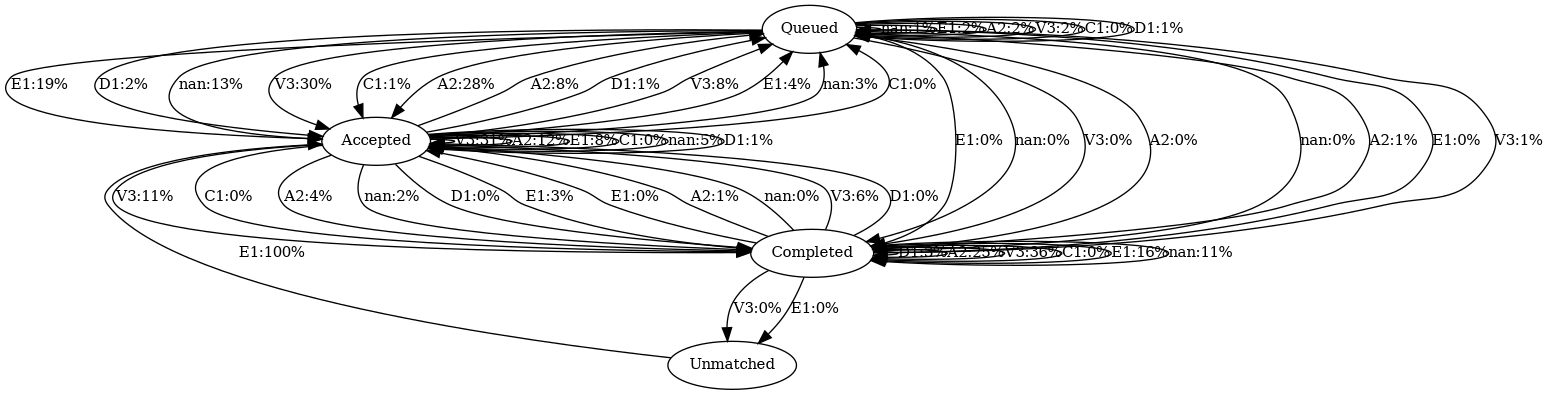

In [133]:
view_resource_markov_chain(data_transition_role_prob)

In [134]:
semi_markov_json = mc_apply(subset_el)

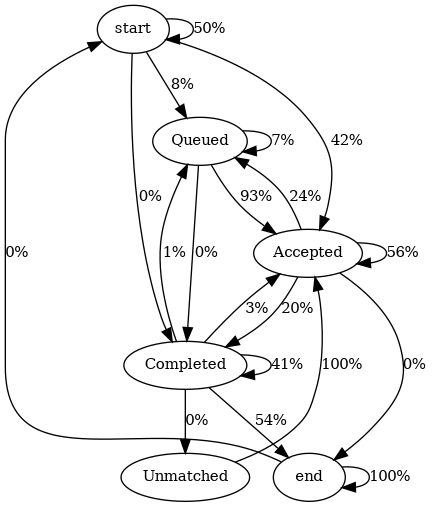

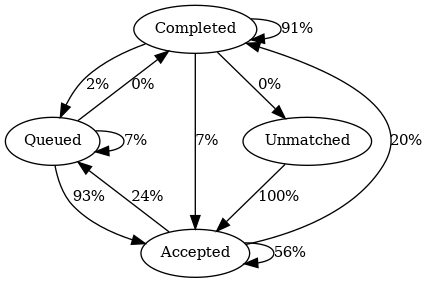

In [135]:
view_markov_chain(semi_markov_json)
view_non_resource_markov_chain(res)

In [153]:
from simulation.ctmc import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')
# print(probabilities)
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

formula_str = f'R=? [F {labels}]'
properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result}")
if result<np.inf:
    print(f"Duration: {datetime.timedelta(seconds=result)}")

KeyError: 'Unmatched'

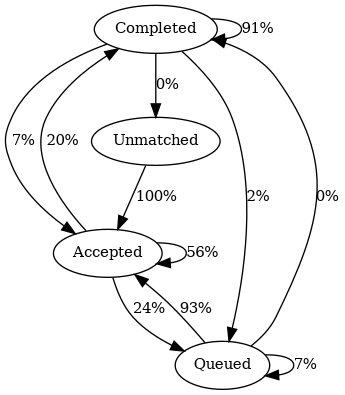

In [18]:
view_non_resource_markov_chain(probabilities)

In [152]:
import json

with open('mean_transition_role_time.json', 'w') as file:
    json.dump(data_mean_transition_role_time, file, indent=4)

with open('role_number_of_resources.json', 'w') as file:
    json.dump(role_resources, file, indent=4)

with open('transition_role_frequency.json', 'w') as file:
    json.dump(data_transition_role_frequency, file, indent=4)

with open('role_trials.json', 'w') as file:
    json.dump(role_trials, file, indent=4)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import fitter
from simulation.markov_models.fit_distribution import fit_gauss

In [51]:
times_dictionary.items()

dict_items([(('Accepted', 'Accepted', 'A2'), [74.0, 8.0, 62402638.0, 8.0, 1879125.0, 6.0, 7.0, 695.0, 46609.0, 155.0, 436.0, 58.0, 4701.0, 134.0, 78808.0, 1108.0, 336740.0, 517.0, 5.0, 362.0, 3886.0, 7245.0, 675267.0, 1.0, 232.0, 86097.0, 8062.0, 83313.0, 80818.0, 5279.0, 90.0, 66.0, 203.0, 246482.0, 69.0, 457701.0, 10.0, 5.0, 4489.0, 21.0, 121.0, 63662.0, 30.0, 308.0, 90217.0, 211.0, 1676.0, 87.0, 7.0, 4.0, 487.0, 423.0, 257842.0, 80595.0, 259205.0, 3185737.0, 182.0, 630.0, 144.0, 213.0, 177171.0, 71898.0, 690.0, 12549.0, 28.0, 413.0, 146.0, 2495067.0, 70.0, 4900.0, 512.0, 118.0, 258556.0, 354508.0, 5.0, 131.0, 2.0, 2.0, 230.0, 217.0, 18.0, 259022.0, 5.0, 7.0, 14.0, 141.0, 288.0, 250.0, 27.0, 4.0, 52259.0, 76.0, 19.0, 37.0, 163.0, 6.0, 56275.0, 75.0, 7.0, 7557.0, 57.0, 4042.0, 362699.0, 321788.0, 6899378.0, 13831656.0, 15.0, 8.0, 8.0, 369649.0, 322643.0, 24293.0, 17443794.0, 34.0, 3449.0, 258377.0, 158028.0, 5009.0, 17972299.0, 100.0, 13.0, 389.0, 258878.0, 325764.0, 177.0, 3019437.0,

2025-03-18 18:31:41.119 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.257128)
2025-03-18 18:31:41.131 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.233198)
2025-03-18 18:31:41.226 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.25006)
2025-03-18 18:31:41.227 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=0.175685)
2025-03-18 18:31:41.230 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.20619)
2025-03-18 18:31:41.241 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.249946)
2025-03-18 18:31:41.452 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.248747)
2025-03-18 18:31:41.453 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

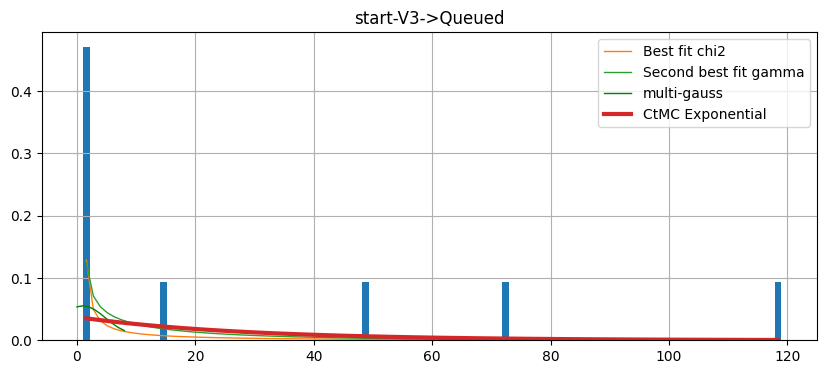

2025-03-18 18:31:42.317 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.028556)
2025-03-18 18:31:42.317 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.028133)
2025-03-18 18:31:42.318 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.029324)
2025-03-18 18:31:42.319 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.020688)
2025-03-18 18:31:42.320 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.026108)
2025-03-18 18:31:42.939 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.023545)
2025-03-18 18:31:42.963 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.012194)
2025-03-18 18:31:42.966 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

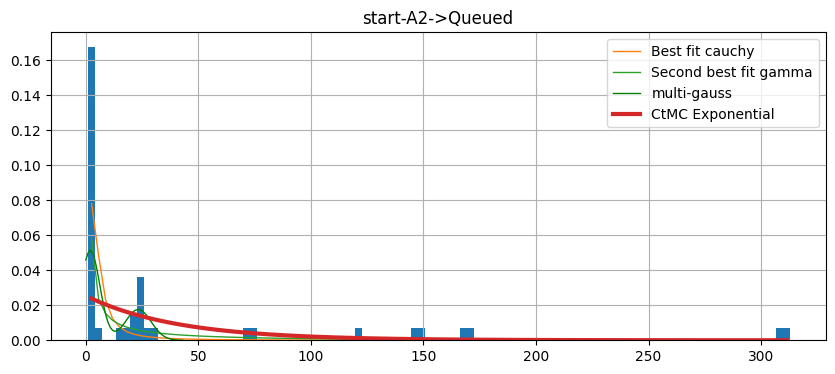

2025-03-18 18:31:43.630 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.001469)
2025-03-18 18:31:43.633 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.002423)
2025-03-18 18:31:43.634 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00125)
2025-03-18 18:31:43.634 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.002163)
2025-03-18 18:31:43.634 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.00224)
2025-03-18 18:31:43.636 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000956)
2025-03-18 18:31:43.640 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.00179)
2025-03-18 18:31:43.655 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

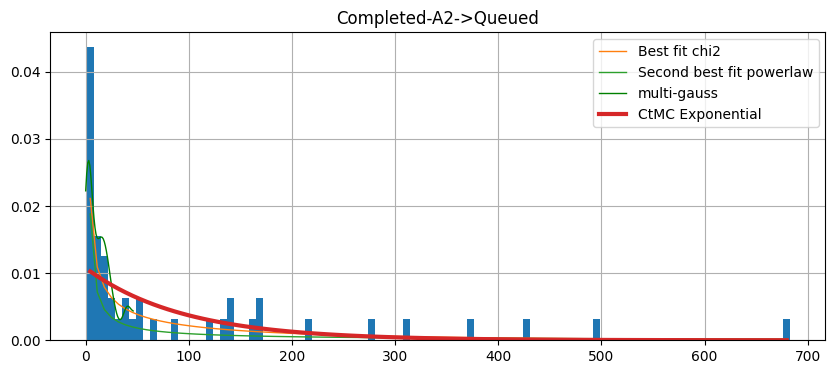

2025-03-18 18:31:46.548 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.014867)
2025-03-18 18:31:46.548 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.015166)
2025-03-18 18:31:46.548 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.012193)
2025-03-18 18:31:46.550 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.014608)
2025-03-18 18:31:46.551 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.01312)
2025-03-18 18:31:46.551 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.007175)
2025-03-18 18:31:46.551 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.012183)
2025-03-18 18:31:46.569 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

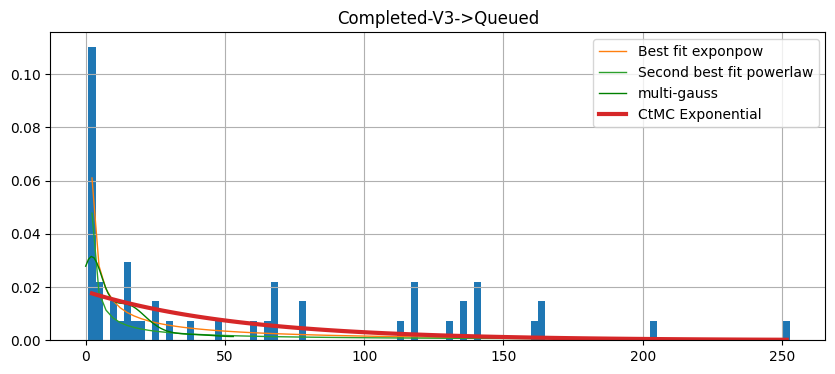

2025-03-18 18:31:47.359 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.8e-05)
2025-03-18 18:31:47.360 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=9.8e-05)
2025-03-18 18:31:47.363 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000112)
2025-03-18 18:31:47.363 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=9.2e-05)
2025-03-18 18:31:47.364 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000102)
2025-03-18 18:31:47.365 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=5.5e-05)
2025-03-18 18:31:47.365 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=8.7e-05)
2025-03-18 18:31:47.384 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi

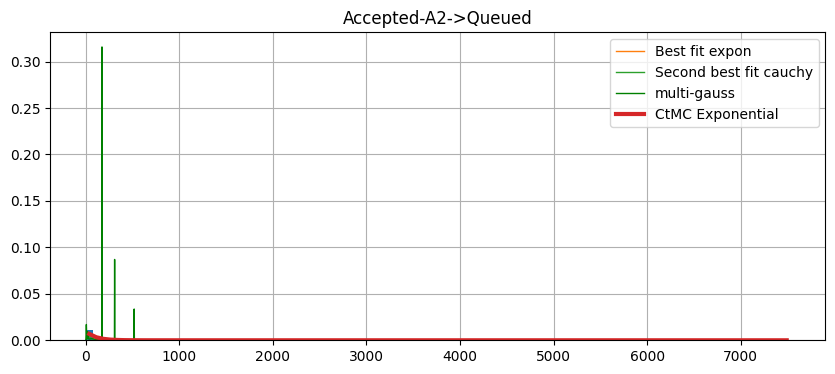

2025-03-18 18:34:03.306 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000213)
2025-03-18 18:34:03.307 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000596)
2025-03-18 18:34:03.309 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000708)
2025-03-18 18:34:03.310 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000558)
2025-03-18 18:34:03.310 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000634)
2025-03-18 18:34:03.313 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000523)
2025-03-18 18:34:03.315 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=9.7e-05)
2025-03-18 18:34:03.339 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

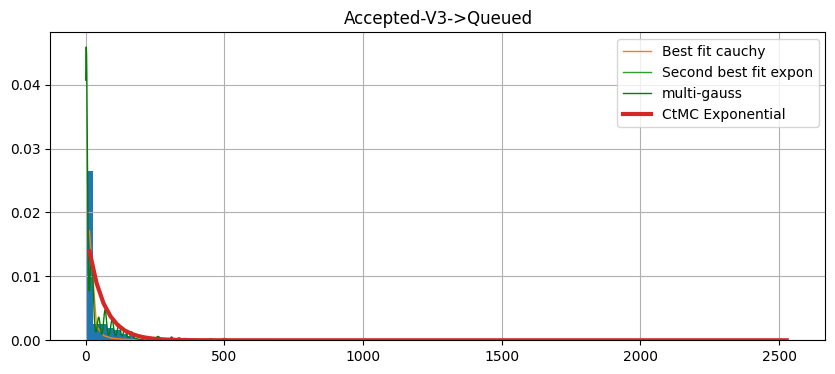

2025-03-18 18:34:13.420 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.7e-05)
2025-03-18 18:34:13.422 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=7e-05)
2025-03-18 18:34:13.422 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6.1e-05)
2025-03-18 18:34:13.424 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=5.7e-05)
2025-03-18 18:34:13.424 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=5e-05)
2025-03-18 18:34:13.427 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=6e-05)
2025-03-18 18:34:13.427 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.1e-05)
2025-03-18 18:34:13.444 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distri

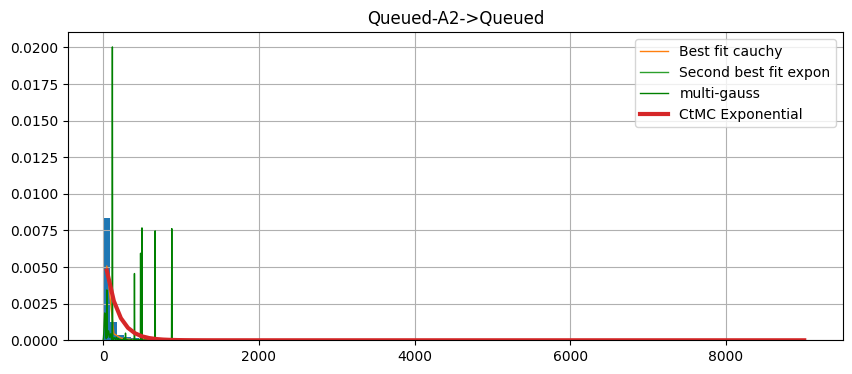

2025-03-18 18:34:23.764 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000173)
2025-03-18 18:34:23.766 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000627)
2025-03-18 18:34:23.767 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000792)
2025-03-18 18:34:23.768 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000575)
2025-03-18 18:34:23.770 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000549)
2025-03-18 18:34:23.771 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-03-18 18:34:23.772 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000686)
2025-03-18 18:34:23.798 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

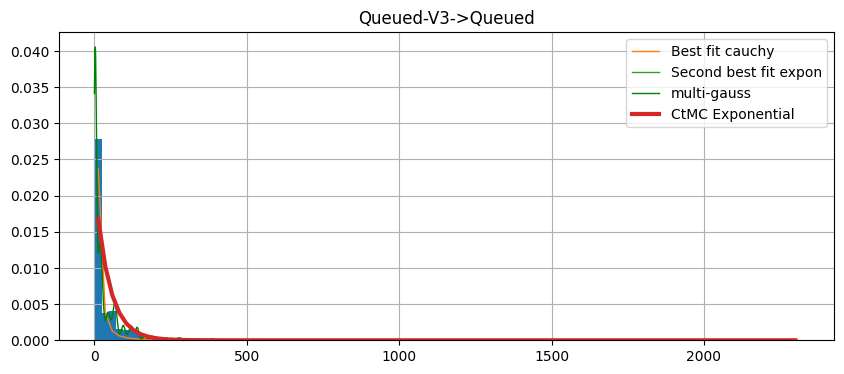

2025-03-18 18:34:29.046 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.161146)
2025-03-18 18:34:29.049 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.35874)
2025-03-18 18:34:29.050 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.390215)
2025-03-18 18:34:29.051 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.30788)
2025-03-18 18:34:29.051 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.34509)
2025-03-18 18:34:29.054 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.363848)
2025-03-18 18:34:29.062 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.40203)
2025-03-18 18:34:29.076 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ch

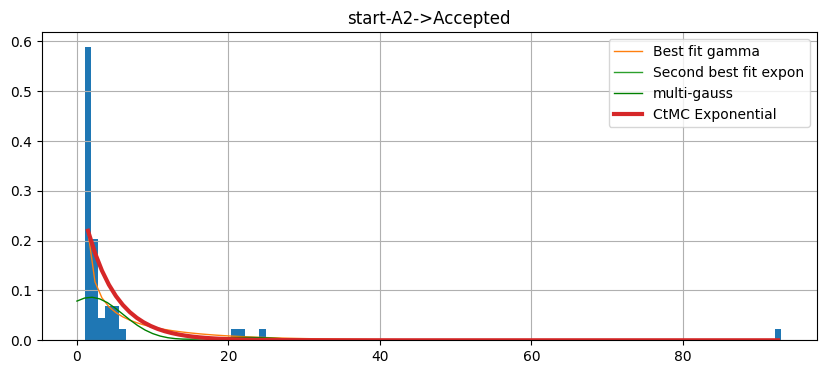

2025-03-18 18:34:29.393 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.412477)
2025-03-18 18:34:29.395 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.708383)
2025-03-18 18:34:29.395 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.681965)
2025-03-18 18:34:29.396 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.667331)
2025-03-18 18:34:29.397 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.671775)
2025-03-18 18:34:29.398 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.585344)
2025-03-18 18:34:29.409 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.725249)
2025-03-18 18:34:29.420 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

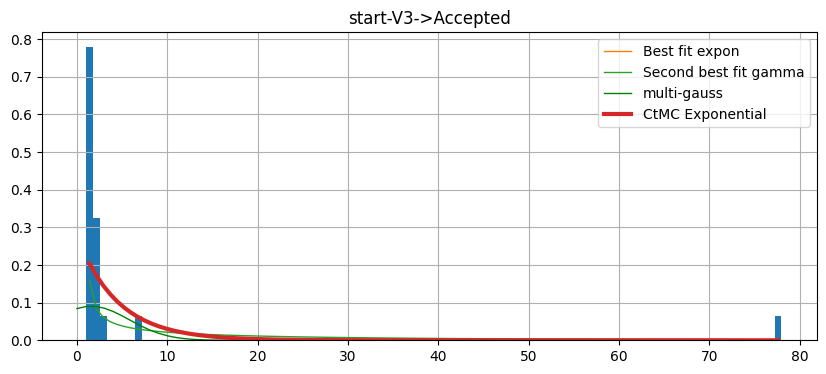

2025-03-18 18:34:29.742 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000705)
2025-03-18 18:34:29.743 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001395)
2025-03-18 18:34:29.743 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.001195)
2025-03-18 18:34:29.743 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.001134)
2025-03-18 18:34:29.746 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000405)
2025-03-18 18:34:29.749 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000896)
2025-03-18 18:34:29.749 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000906)
2025-03-18 18:34:29.768 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

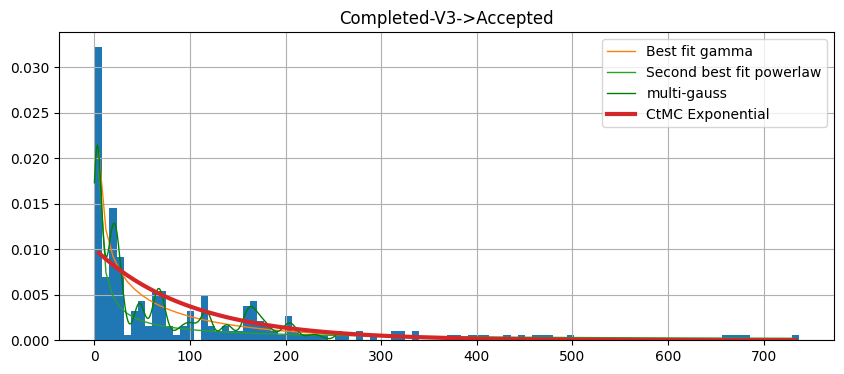

2025-03-18 18:34:35.823 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000976)
2025-03-18 18:34:35.823 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.001597)
2025-03-18 18:34:35.825 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001785)
2025-03-18 18:34:35.825 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.001526)
2025-03-18 18:34:35.827 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.001253)
2025-03-18 18:34:35.828 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00058)
2025-03-18 18:34:35.828 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00103)
2025-03-18 18:34:35.864 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

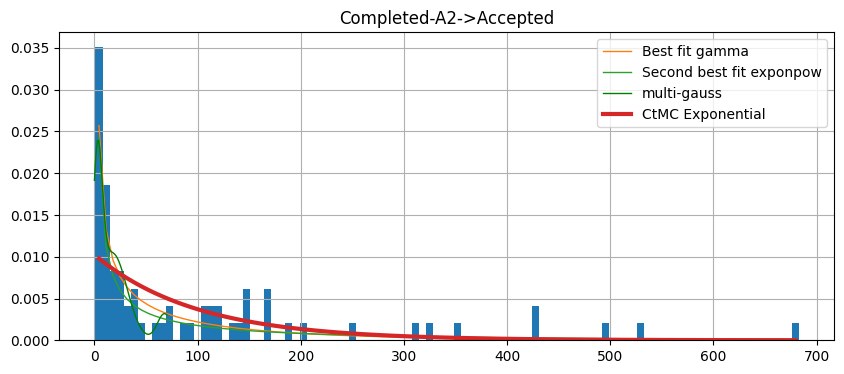

2025-03-18 18:34:39.475 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4e-06)
2025-03-18 18:34:39.476 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2e-05)
2025-03-18 18:34:39.477 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.5e-05)
2025-03-18 18:34:39.478 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=1.9e-05)
2025-03-18 18:34:39.485 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=2.2e-05)
2025-03-18 18:34:39.485 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=1.9e-05)
2025-03-18 18:34:39.488 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.5e-05)
2025-03-18 18:34:39.509 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 dist

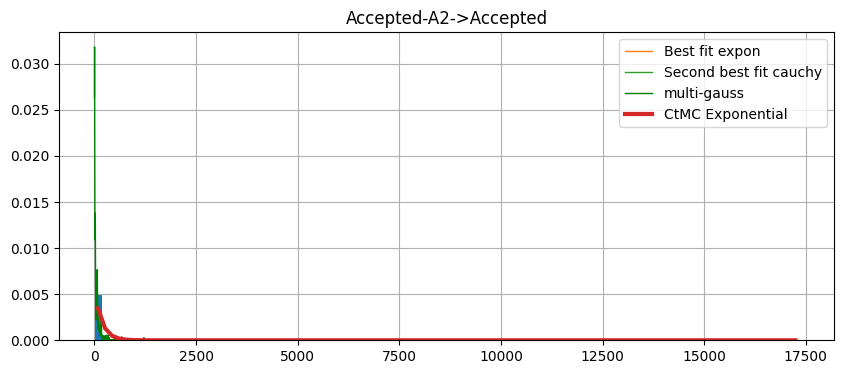

2025-03-18 18:34:48.743 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.4e-05)
2025-03-18 18:34:48.745 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000242)
2025-03-18 18:34:48.747 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000314)
2025-03-18 18:34:48.747 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000218)
2025-03-18 18:34:48.748 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-03-18 18:34:48.750 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000224)
2025-03-18 18:34:48.752 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000276)
2025-03-18 18:34:48.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

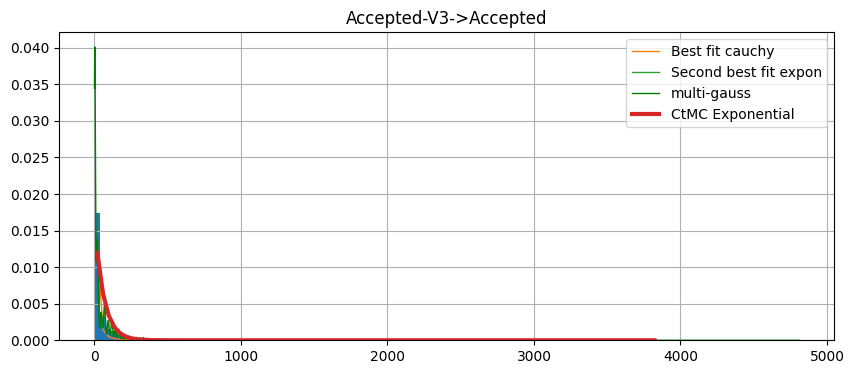

2025-03-18 18:34:56.172 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3.8e-05)
2025-03-18 18:34:56.173 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000236)
2025-03-18 18:34:56.173 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000196)
2025-03-18 18:34:56.174 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000182)
2025-03-18 18:34:56.177 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=7.8e-05)
2025-03-18 18:34:56.178 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000211)
2025-03-18 18:34:56.179 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000179)
2025-03-18 18:34:56.209 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

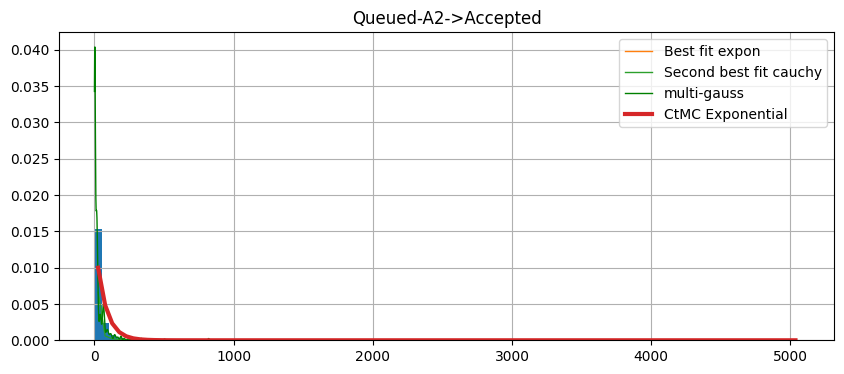

2025-03-18 18:35:03.528 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000153)
2025-03-18 18:35:03.528 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3e-06)
2025-03-18 18:35:03.528 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000106)
2025-03-18 18:35:03.530 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8.8e-05)
2025-03-18 18:35:03.531 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000138)
2025-03-18 18:35:03.535 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000119)
2025-03-18 18:35:03.535 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=6.9e-05)
2025-03-18 18:35:03.559 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gam

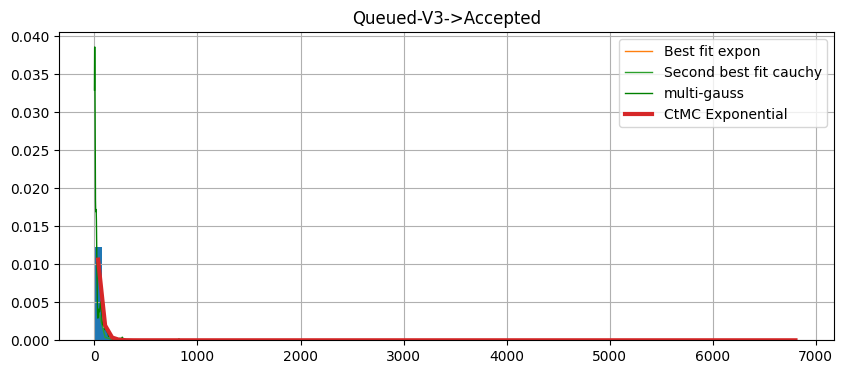

2025-03-18 18:35:07.080 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.00355)
2025-03-18 18:35:07.080 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.003988)
2025-03-18 18:35:07.080 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.00381)
2025-03-18 18:35:07.082 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.003224)
2025-03-18 18:35:07.082 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.003815)
2025-03-18 18:35:07.083 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003286)
2025-03-18 18:35:07.084 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002026)
2025-03-18 18:35:07.113 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

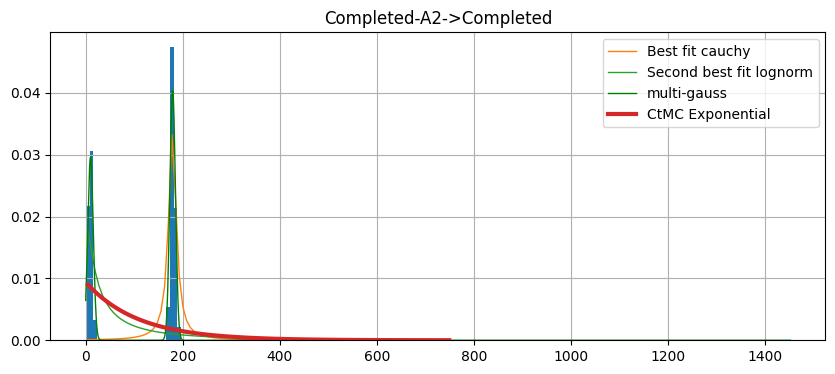

2025-03-18 18:35:07.498 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.004271)
2025-03-18 18:35:07.498 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.004384)
2025-03-18 18:35:07.499 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.004598)
2025-03-18 18:35:07.499 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.004423)
2025-03-18 18:35:07.500 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.004075)
2025-03-18 18:35:07.504 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00128)
2025-03-18 18:35:07.505 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003979)
2025-03-18 18:35:07.558 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

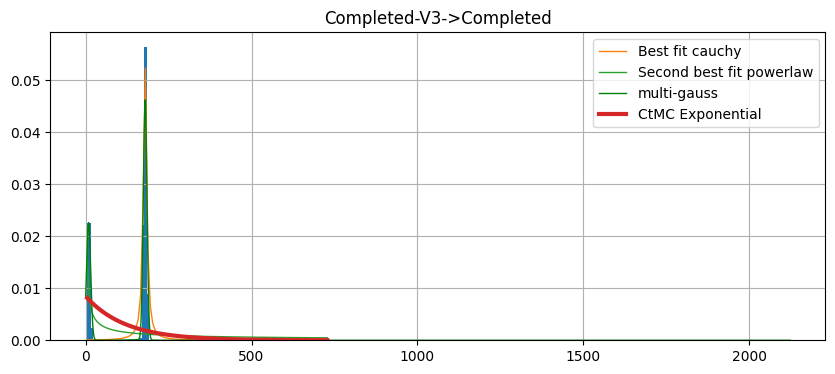

2025-03-18 18:35:07.964 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=2.7e-05)
2025-03-18 18:35:07.965 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=5.4e-05)
2025-03-18 18:35:07.966 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.8e-05)
2025-03-18 18:35:07.966 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=5e-05)
2025-03-18 18:35:07.967 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=3.8e-05)
2025-03-18 18:35:07.970 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=9e-06)
2025-03-18 18:35:07.972 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=2.8e-05)
2025-03-18 18:35:07.989 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 dist

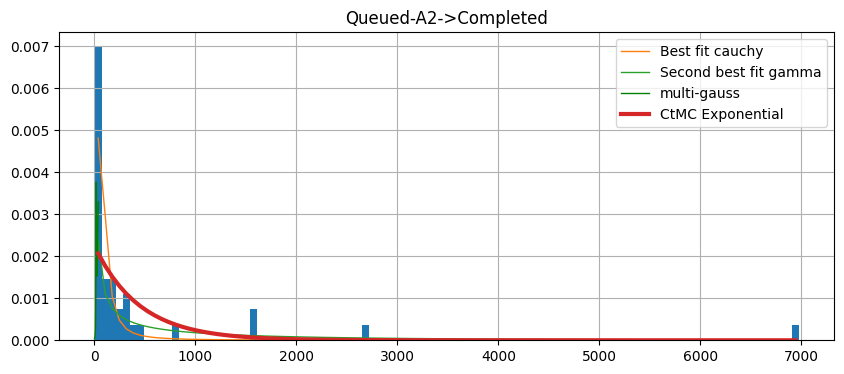

2025-03-18 18:35:30.541 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000531)
2025-03-18 18:35:30.543 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000905)
2025-03-18 18:35:30.543 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000868)
2025-03-18 18:35:30.544 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001009)
2025-03-18 18:35:30.545 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000279)
2025-03-18 18:35:30.546 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000862)
2025-03-18 18:35:30.547 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00061)
2025-03-18 18:35:30.567 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

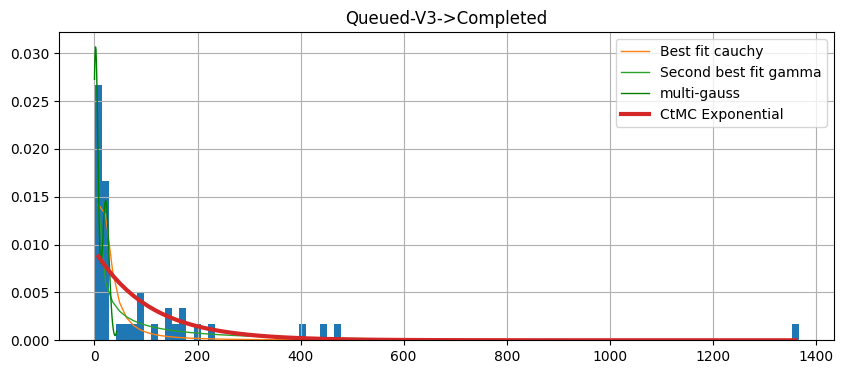

2025-03-18 18:35:33.322 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=nan)
2025-03-18 18:35:33.322 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=nan)
2025-03-18 18:35:33.323 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=nan)
2025-03-18 18:35:33.328 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED gamma distribution (taking more than 30 seconds)
2025-03-18 18:35:33.332 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=10000.0)
2025-03-18 18:35:33.347 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=10000.0)
2025-03-18 18:35:33.362 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=8825.60241)
2025-03-18 18:35:33.382 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw 

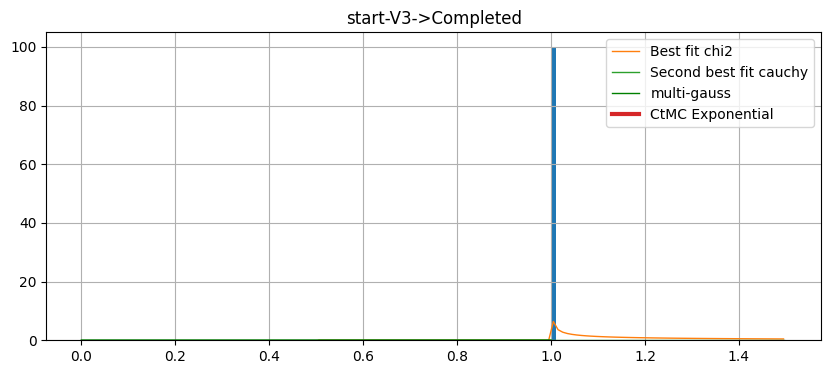

2025-03-18 18:35:33.794 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.01678)
2025-03-18 18:35:33.796 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.016918)
2025-03-18 18:35:33.797 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.016442)
2025-03-18 18:35:33.797 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.01684)
2025-03-18 18:35:33.798 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.016861)
2025-03-18 18:35:33.798 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.01563)
2025-03-18 18:35:33.799 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.01676)
2025-03-18 18:35:33.820 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ch

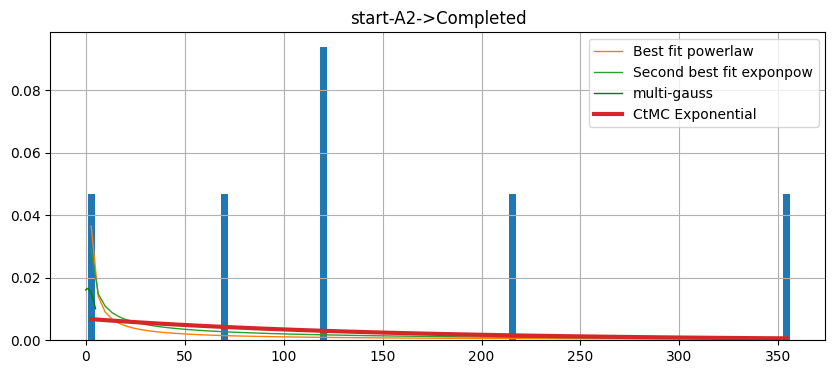

2025-03-18 18:35:34.180 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.6e-05)
2025-03-18 18:35:34.181 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000108)
2025-03-18 18:35:34.182 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000131)
2025-03-18 18:35:34.183 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000101)
2025-03-18 18:35:34.184 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-03-18 18:35:34.185 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.6e-05)
2025-03-18 18:35:34.185 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=9.9e-05)
2025-03-18 18:35:34.211 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ga

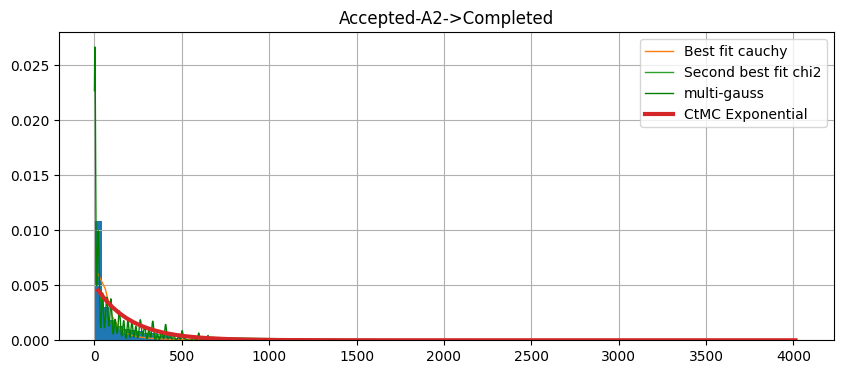

2025-03-18 18:35:41.375 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=9.9e-05)
2025-03-18 18:35:41.375 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.00021)
2025-03-18 18:35:41.376 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000226)
2025-03-18 18:35:41.376 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000285)
2025-03-18 18:35:41.378 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000122)
2025-03-18 18:35:41.379 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000221)
2025-03-18 18:35:41.379 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000145)
2025-03-18 18:35:41.411 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

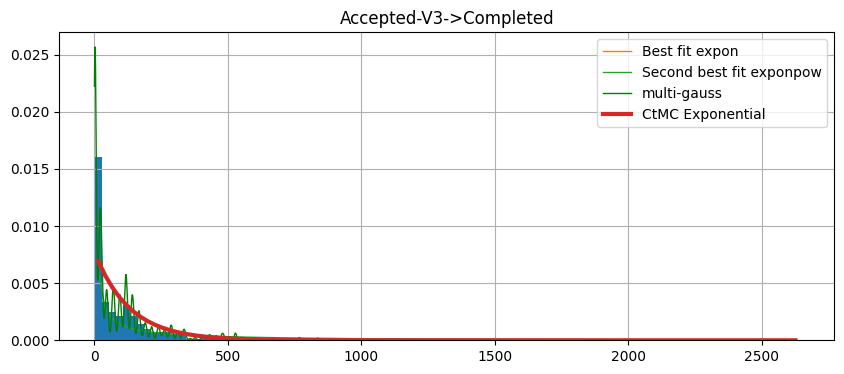

2025-03-18 18:35:48.936 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.33839)
2025-03-18 18:35:48.938 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.340278)
2025-03-18 18:35:48.938 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.343735)
2025-03-18 18:35:48.938 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.343476)
2025-03-18 18:35:48.941 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.344404)
2025-03-18 18:35:48.942 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.297227)
2025-03-18 18:35:48.943 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.325561)
2025-03-18 18:35:48.949 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

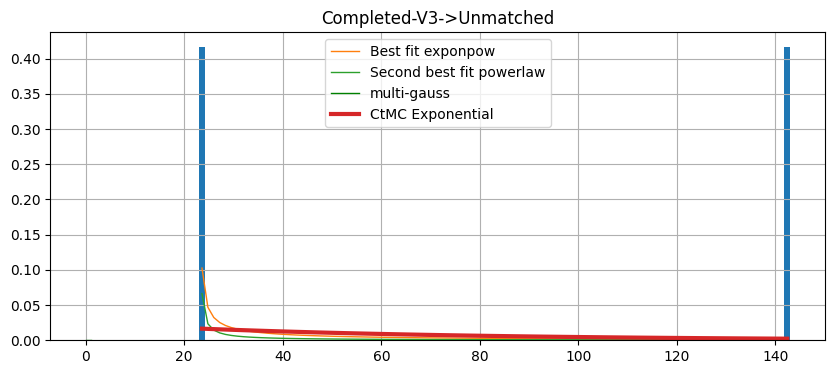

In [138]:
eval_functions = pd.DataFrame()

seed=None

for k, v in times_dictionary.items():
    s1 = k[0]
    s2 = k[1]
    role = k[2]
    v = np.array(v)
    v = v // 3600
    # do we remove 0 values?
    v = v[v != 0]
    if len(v) != 0 and role in ['V3','A2']:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        f = fitter.Fitter(v,distributions=fitter.get_common_distributions())
        f.fit()
        best_dist, fitted_params = f.get_best().popitem()
        best_two_summary = f.summary(Nbest=2,plot=True,lw=1)

        kde = sm.nonparametric.KDEUnivariate(v)
        kde.fit(bw=4, kernel='gau')  # Estimate the densities
        multi_gauss = fit_gauss(kde.support, kde.density, v)
        x = [i for i in range(len(v))]
        multi_gauss.plot_mult_gauss(x,label='multi-gauss',color='g')
        ks_stat, ks_pval, kl_div = multi_gauss.fitted_results(v)
        best_two_summary.loc['multi-gauss'] = [np.inf,np.inf,np.inf,kl_div,ks_stat,ks_pval]

        f = fitter.Fitter(v,distributions=['expon'])
        f.fit()
        rate = f.get_best()
        best_expon, fitted_expon = f.get_best().popitem()
        f.plot_pdf(names=['expon'],lw=3)
        expon_summary = f.summary(Nbest=1,plot=False)

        # plt.xlim([0,500])
        plt.title(f'{s1}-{role}->{s2}')
        plt.legend(labels=[f'Best fit {best_two_summary.index[0]}',f'Second best fit {best_two_summary.index[1]}','multi-gauss',f'CtMC Exponential'])
        plt.savefig(f"/home/vco/Writing/simulation/figs/timeeval/{s1}-{role}-{s2}.png",format='png',pad_inches=0)
        plt.show()

        fit_summary = pd.concat([expon_summary, best_two_summary])
        fit_summary['from'] = s1
        fit_summary['to'] = s2
        fit_summary['role'] = role
        eval_functions = pd.concat([eval_functions,fit_summary])